In [10]:
import cv2, os, numpy as np, matplotlib.pyplot as plt, pickle

from sklearn.svm import SVC
from xgboost import XGBClassifier

from skimage import feature

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
# PATH = './zoomed_hands_dataset/train/'
PATH = './new_dataset/combined/'
FACE_CASCADE_PATH = 'haarcascade_frontalface_default.xml'
labels = set()
class_list = []
images = []


In [12]:
def load_image(image_path, face_cascade):
    img = cv2.imread(image_path)
    detected_faces = face_cascade.detectMultiScale(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), scaleFactor=1.2, minNeighbors=5, minSize=(35, 35))
    if len(detected_faces) > 0:
        for (x, y, w, h) in detected_faces: 
            img[y:y+h, x:x+w] = 0
    img = cv2.resize(img, (256, 256))
    return img

face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)
for i, folder in enumerate(os.listdir(PATH)):
    labels.add(folder)
    for j, file in enumerate(os.listdir(PATH + folder)):
        img = load_image(os.path.join(PATH, folder, file), face_cascade)
        images.append(img)
        class_list.append(folder)

labels = list(labels)
y = []
for label in class_list:
    new_label = labels.index(label)
    y.append(new_label)


In [13]:
print(labels)

['Membaca', 'Siapa', 'Lelah', 'Nama', 'Berhenti', 'Sombong', 'Apa', 'Maaf', 'Anda', 'Halo', 'Mau-Ingin', 'Sama-sama', 'Saya', 'Takut', 'Hati-hati', 'Makan', 'Terima kasih', 'Cantik', 'Bodoh']


In [14]:
def getmask(img):
    img= cv2.cvtColor(cv2.medianBlur(img,7),cv2.COLOR_BGR2HSV)

    lower = np.array([0,100,0], dtype = "uint8")
    upper = np.array([20,255,255], dtype = "uint8")
    mask1 = cv2.inRange(img,lower,upper)

    lower = np.array([0, 30, 60], dtype = "uint8")
    upper = np.array([20, 150, 255], dtype = "uint8")
    mask2 = cv2.inRange(img,lower,upper)

    mask = cv2.bitwise_or(mask1, mask2)
    
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    length = len(contours)
    maxArea = -1
    if length > 0:
        ci = 0
        for i in range(length):
            temp = contours[i]
            area = cv2.contourArea(temp)
            if area > maxArea:
                maxArea = area
                ci = i
        res1 = contours[ci]
        maxArea = -1
        ci2 = -1
        for i in range(length):
            temp = contours[i]
            area = cv2.contourArea(temp)
            if area > maxArea and i != ci and area >= cv2.contourArea(res1) * 0.7:
                maxArea = area
                ci2 = i
        
        mask = np.zeros(mask.shape, np.uint8)
        cv2.fillPoly(mask, [res1], color=(255, 255, 255))
        if ci2 >= 0:
            cv2.fillPoly(mask, [contours[ci2]], color=(255, 255, 255))

    binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]
    mask = cv2.bitwise_and(img,img, mask = binary_mask)
    x_t, y_t, w_t, h_t = cv2.boundingRect(binary_mask)
    mask = mask[y_t:y_t+h_t, x_t:x_t+w_t]
    mask = cv2.resize(mask, (96, 96))
    return mask

In [15]:
def compute_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_BGR2GRAY)
    hog_features, hogImage = feature.hog(gray_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_features

In [16]:
features = []
for i, img in enumerate(images):
    f = compute_hog_features(getmask(img))
    features.append(f)
features = np.array(features)

x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state=42, shuffle=True)

In [22]:
print(len(y_train), len(y_test))

3302 367


In [17]:
def modeling(x_train, x_test, y_train, y_test):
    #SVC
    SVM = SVC(max_iter=1000, kernel='rbf')
    SVM.fit(x_train, y_train)
    SVC_prediction = SVM.predict(x_test)
    with open('SVC.pkl','wb') as f:
        pickle.dump(SVM,f)

    #XGBoost
    XGB = XGBClassifier()
    XGB.fit(x_train, y_train)
    XGB_prediction = XGB.predict(x_test)
    with open('XGB.pkl','wb') as f:
        pickle.dump(XGB,f)

    return SVC_prediction, XGB_prediction


In [18]:
svc_result, xgb_result = modeling(x_train, x_test, y_train, y_test)

In [19]:
def confmatrix(y_test, predictions):
    display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions), display_labels = labels)
    fig, ax = plt.subplots(figsize=(8,8))
    print(f"Confusion Matrix:\n")
    display.plot(ax=ax, xticks_rotation='vertical')
    plt.show()

SVC
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.55      0.89      0.68        18
           2       0.92      0.86      0.89        14
           3       0.60      0.64      0.62        14
           4       0.85      0.89      0.87        19
           5       0.73      0.48      0.58        23
           6       1.00      1.00      1.00        27
           7       0.60      0.67      0.63         9
           8       0.83      0.61      0.70        31
           9       1.00      0.90      0.95        21
          10       0.82      0.92      0.87        25
          11       0.80      0.80      0.80        15
          12       0.58      0.83      0.68        18
          13       1.00      0.97      0.98        33
          14       0.75      1.00      0.86        15
          15       0.74      0.54      0.62        26
          16       0.83      0.88      0.86        17
          17       0.93

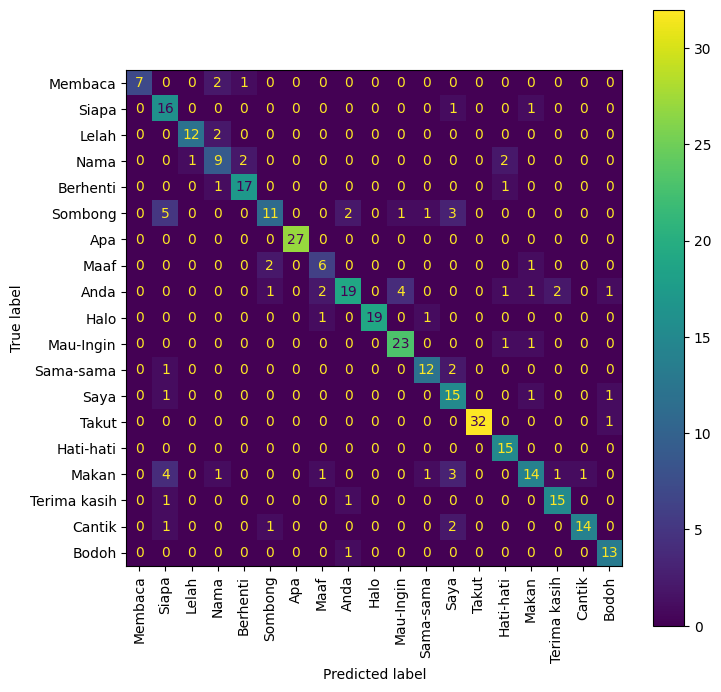

In [20]:
print('SVC')
print(classification_report(y_test, svc_result))
confmatrix(y_test, svc_result)

XGB
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.63      0.94      0.76        18
           2       1.00      0.93      0.96        14
           3       0.90      0.64      0.75        14
           4       0.79      0.79      0.79        19
           5       0.62      0.57      0.59        23
           6       0.93      1.00      0.96        27
           7       0.38      0.56      0.45         9
           8       0.80      0.65      0.71        31
           9       0.94      0.76      0.84        21
          10       0.85      0.92      0.88        25
          11       0.82      0.60      0.69        15
          12       0.67      0.89      0.76        18
          13       1.00      1.00      1.00        33
          14       0.67      0.93      0.78        15
          15       0.71      0.65      0.68        26
          16       0.88      0.88      0.88        17
          17       1.00

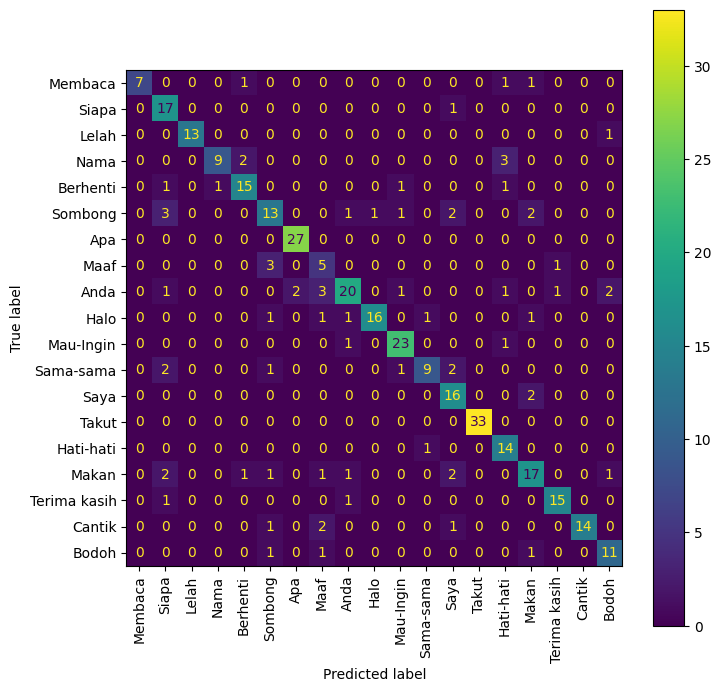

In [21]:
print('XGB')
print(classification_report(y_test, xgb_result))
confmatrix(y_test, xgb_result)